In [12]:
import pandas as pd
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [13]:
# Get S&P 500 tickers
def get_sp500_tickers(sample_size=250):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [14]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-01-01", end="2024-09-10")
        data[i] = stock_data['Adj Close']
    return data

In [15]:
# Perform the ADF test for stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

In [16]:
# Cointegration test between pairs of stocks
def cointegration_test(data):
    pairs = []
    results = []
    
    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()
            
            x, y = x.align(y, join='inner')  # Align x and y by matching labels (dates)
            if x.empty or y.empty:
                continue
            
            try:
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue
            
            ratio = x / y
            adf_p_value = adf_test(ratio)
            
            pairs.append((tickers[i], tickers[j]))
            results.append((tickers[i], tickers[j], score, p_value, adf_p_value))
    
    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value'])
    return results_df

In [17]:
# Calculate z-score for the ratio
def calculate_zscore(ratio):
    mean = ratio.rolling(window=30).mean()
    std = ratio.rolling(window=30).std()
    zscore = (ratio - mean) / std
    return zscore

In [18]:
# Generate features and target
def generate_features_and_target(ratio):
    z_score = calculate_zscore(ratio).dropna()
    
    # Define target: 1 if the ratio increases, -1 if the ratio decreases
    target = np.where(ratio.shift(-21) > ratio, 1, -1)
    
    # Align the target to match the z-score indices
    target = pd.Series(target, index=ratio.index)
    
    # Drop rows with NaN values after calculating the z-score
    z_score = z_score.dropna()
    target = target.loc[z_score.index]
    
    return z_score, target

In [19]:
# Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Cointegration test
results_df = cointegration_test(historical_data)

# Filter pairs with the lowest ADF p-values
filtered_results = results_df[results_df['ADF p-value'] < 0.05]

# Sort pairs by cointegration score to find the most cointegrated pair
sorted_results = filtered_results.sort_values(by='Cointegration Score', ascending=True)

# Get the top cointegrated pair
top_pair = sorted_results.iloc[0]
stock1, stock2 = top_pair['Stock 1'], top_pair['Stock 2']

# Calculate the ratio for the top pair
ratio = historical_data[stock1] / historical_data[stock2]

# Generate features and target for the ratio
z_score, target = generate_features_and_target(ratio)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(z_score.values.reshape(-1, 1), target, test_size=0.2, random_state=42, shuffle=False)

# Train a Random Forest classifier
model = SVC(kernel='rbf', C=1.0)
#model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict signals on the test set
y_pred = model.predict(X_test)

print("historica_data:", historical_data.head())
print("results_df:", results_df.head())
print("filtered_results:", filtered_results.head())
print("sorted_results:", sorted_results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

historica_data:                   KDP        HWM       ORCL        LKQ        AAPL       TRGP  \
Date                                                                            
2022-01-03  34.389030  32.043400  84.268784  55.096363  179.273621  50.009541   
2022-01-04  34.904263  33.232761  85.169952  55.923615  176.998337  51.070972   
2022-01-05  34.864716  33.024624  82.888268  55.199768  172.290222  50.779781   
2022-01-06  35.241329  33.351696  83.080711  55.801395  169.414124  52.188774   
2022-01-07  35.118923  33.708500  84.206566  54.776741  169.581543  52.517525   

                 NDAQ        NXPI         MAA         DPZ  ...         CCI  \
Date                                                       ...               
2022-01-03  64.790932  219.249985  205.255783  533.683838  ...  181.378418   
2022-01-04  63.168461  220.814545  206.399475  516.377258  ...  176.497787   
2022-01-05  62.410000  212.944275  202.614395  502.148193  ...  164.545013   
2022-01-06  62.550812  215

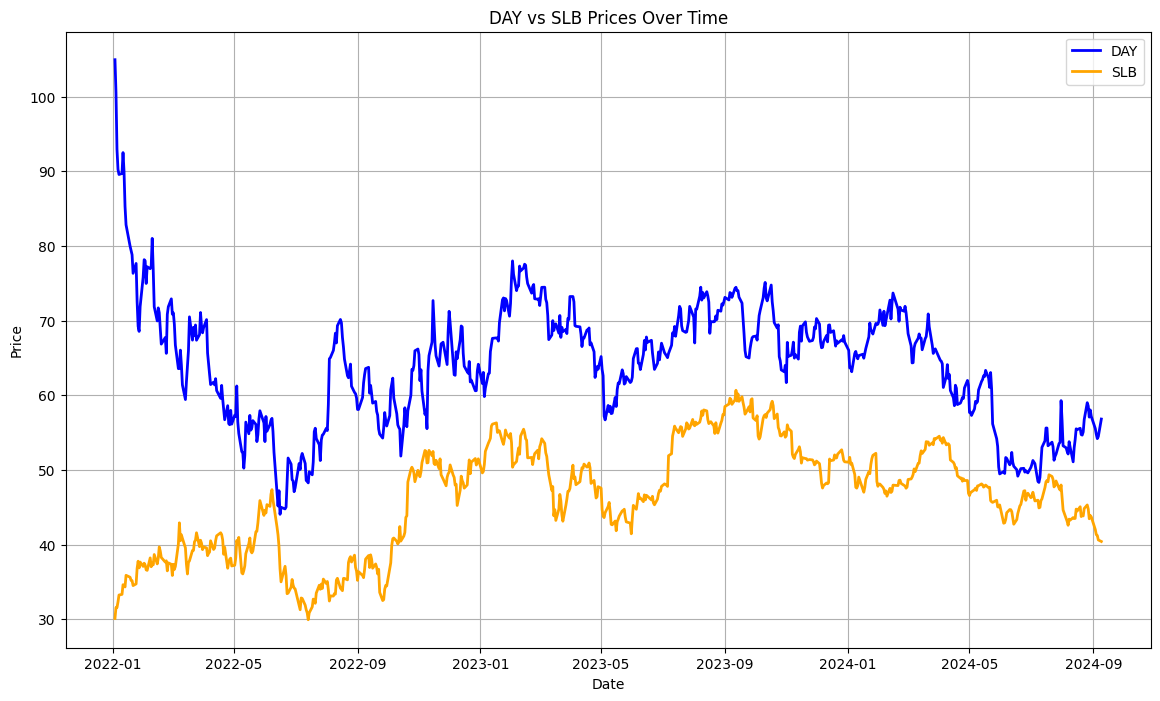

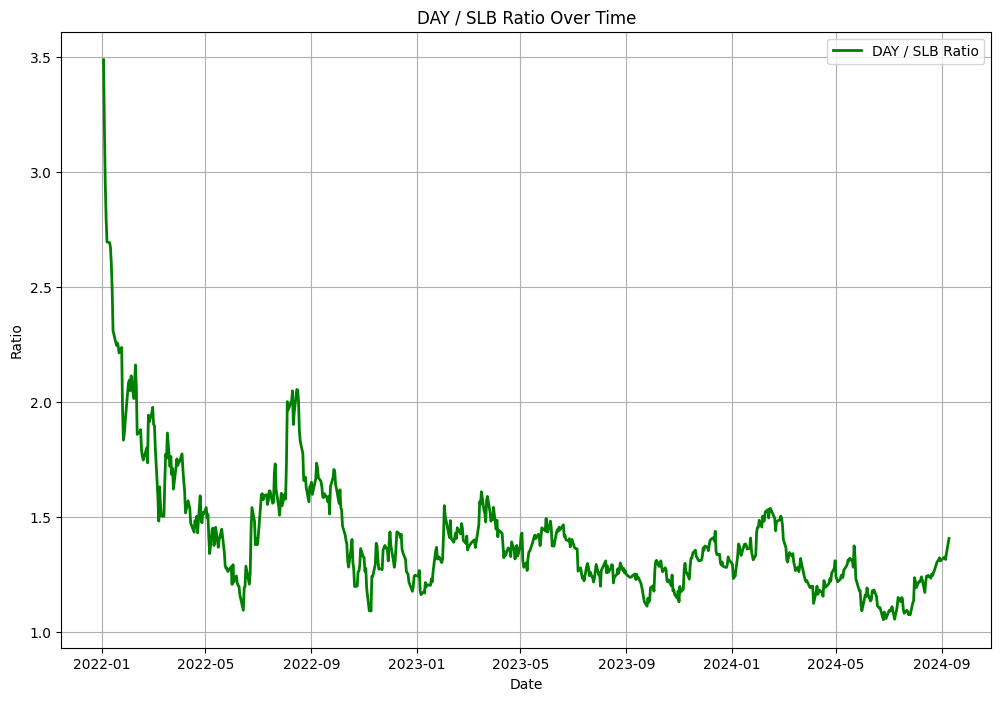

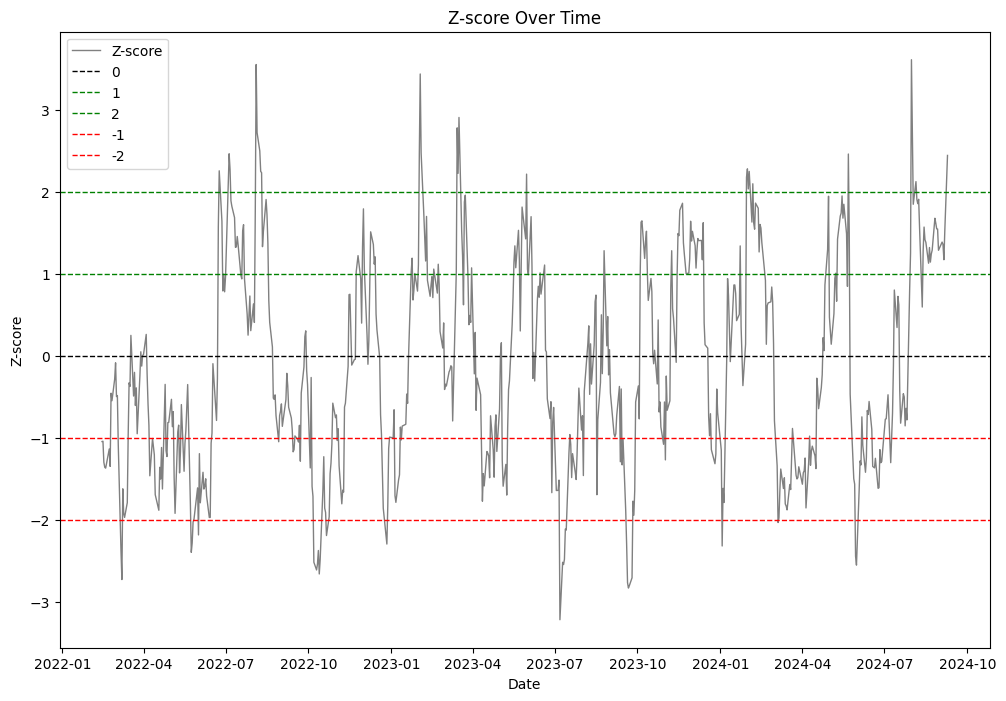

In [20]:
# Plot Stock 1 and Stock 2 Prices
def plot_stocks(stock1, stock2, historical_data):
    plt.figure(figsize=(14, 8))
    
    # Plot stock1 price
    plt.plot(historical_data[stock1], label=stock1, color='blue', linewidth=2)
    
    # Plot stock2 price
    plt.plot(historical_data[stock2], label=stock2, color='orange', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} vs {stock2} Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Ratio (Stock 1 / Stock 2)
def plot_ratio(ratio):
    plt.figure(figsize=(12, 8))
    
    # Plot the ratio of Stock 1 to Stock 2
    plt.plot(ratio, label=f'{stock1} / {stock2} Ratio', color='green', linewidth=2)
    
    # Labels and title
    plt.title(f'{stock1} / {stock2} Ratio Over Time')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot z-score
def plot_zscore(zscore):
    plt.figure(figsize=(12, 8))
    plt.plot(zscore, label='Z-score', color='gray', linewidth=1)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='0')
    plt.axhline(y=1, color='green', linestyle='--', linewidth=1, label='1')
    plt.axhline(y=2, color='green', linestyle='--', linewidth=1, label='2')
    plt.axhline(y=-1, color='red', linestyle='--', linewidth=1, label='-1')
    plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2')

    # Labels and title
    plt.title('Z-score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.legend()
    plt.show()

# Call the functions to plot
plot_stocks(stock1, stock2, historical_data)
plot_ratio(ratio)
plot_zscore(z_score)

In [21]:
# Define test period stock prices for the top cointegrated pair
stock1_prices_test = historical_data[stock1][-len(y_test):]
stock2_prices_test = historical_data[stock2][-len(y_test):]

# Backtest using ML signals
def backtest_ml_strategy(stock1_prices, stock2_prices, ml_predictions, z_score):
    positions = []
    returns = []
    
    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(ml_predictions) - 21):  # Ensure enough days to look ahead 21 days
        if ml_predictions[i] == 1 and position is None:
            # Enter long (Long Stock 1, Short Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            exit_stock1_price = stock1_prices.iloc[i + 21]  # Exit 21 days later
            exit_stock2_price = stock2_prices.iloc[i + 21]  # Exit 21 days later
            position = 'long'
            positions.append(('long', i))

            # Calculate return for a long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            
            # Record the exit
            positions.append(('exit', i + 21))
            position = None  # Exit immediately

        elif ml_predictions[i] == -1 and position is None:
            # Enter short (Short Stock 1, Long Stock 2)
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            exit_stock1_price = stock1_prices.iloc[i + 21]  # Exit 21 days later
            exit_stock2_price = stock2_prices.iloc[i + 21]  # Exit 21 days later
            position = 'short'
            positions.append(('short', i))

            # Calculate return for a short position
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            long_return = (exit_stock2_price - entry_stock2_price) / entry_stock2_price
            returns.append(short_return - long_return)

            # Record the exit
            positions.append(('exit', i + 21))
            position = None  # Exit immediately

    return positions, returns

# Call the backtest function with appropriate inputs
positions, returns = backtest_ml_strategy(stock1_prices_test, stock2_prices_test, y_pred, z_score[-len(y_test):])

# Converting returns to a pandas Series
returns = pd.Series(returns)

# Calculating risk-free rate
risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

# Excess returns (returns - daily risk-free rate)
excess_returns = returns - daily_risk_free_rate

# Mean of excess returns
mean_excess_return = excess_returns.mean()

# Standard deviation of returns (volatility)
volatility = returns.std()

sharpe_ratio = mean_excess_return / volatility

# Print positions and returns
print("Positions:", positions)
print("Returns:", returns)
print("Total return:", sum(returns))
print(f"Sharpe Ratio: {sharpe_ratio}")

Positions: [('long', 0), ('exit', 21), ('long', 1), ('exit', 22), ('long', 2), ('exit', 23), ('long', 3), ('exit', 24), ('long', 4), ('exit', 25), ('long', 5), ('exit', 26), ('long', 6), ('exit', 27), ('long', 7), ('exit', 28), ('long', 8), ('exit', 29), ('long', 9), ('exit', 30), ('long', 10), ('exit', 31), ('short', 11), ('exit', 32), ('long', 12), ('exit', 33), ('long', 13), ('exit', 34), ('long', 14), ('exit', 35), ('long', 15), ('exit', 36), ('long', 16), ('exit', 37), ('long', 17), ('exit', 38), ('long', 18), ('exit', 39), ('long', 19), ('exit', 40), ('long', 20), ('exit', 41), ('long', 21), ('exit', 42), ('long', 22), ('exit', 43), ('long', 23), ('exit', 44), ('long', 24), ('exit', 45), ('long', 25), ('exit', 46), ('long', 26), ('exit', 47), ('long', 27), ('exit', 48), ('long', 28), ('exit', 49), ('short', 29), ('exit', 50), ('short', 30), ('exit', 51), ('short', 31), ('exit', 52), ('short', 32), ('exit', 53), ('short', 33), ('exit', 54), ('short', 34), ('exit', 55), ('short', 3

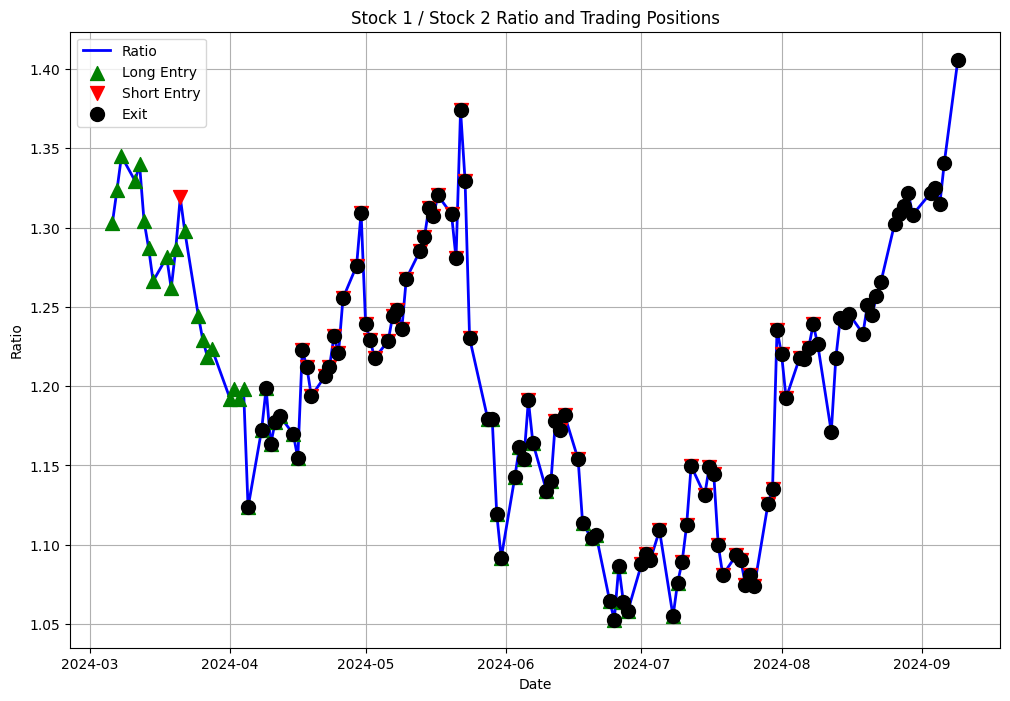

In [24]:
# Plotting function for the ratio and positions
def plot_ratio_with_positions(ratio, positions):
    plt.figure(figsize=(12, 8))
    
    # Plot the ratio as a line graph
    plt.plot(ratio.index, ratio, label="Ratio", color='blue', linewidth=2)
    
    # Separate the position types (long, short, and exit)
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']
    
    # Plot long positions as green dots (triangle up)
    plt.scatter(ratio.index[long_positions], ratio.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    
    # Plot short positions as red dots (triangle down)
    plt.scatter(ratio.index[short_positions], ratio.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    
    # Plot exit positions as black dots (circle)
    plt.scatter(ratio.index[exit_positions], ratio.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)
    
    # Adding labels and title
    plt.title(f"Stock 1 / Stock 2 Ratio and Trading Positions")
    plt.xlabel("Date")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Call the plot function with the ratio and positions from the backtest
plot_ratio_with_positions(ratio[-len(y_test):], positions)